# How-to: Anomaly detection in nanoseconds on an FPGA

<img src="images/front.png" alt="The ADC2021 Challenge" width="300" img align="right"/>

In this notebook we will demonstrate how to design a tiny autoencoder (AE) that we will use for anomaly detection in particle physics. More specifically, we will demonstrate how we can use autoencoders to select potentially New Physics enhanced proton collision events in a more unbiased way than with the usual Level-1 trigger algorithms!

Some of the key tools we will use in order to make our AE fast and small enought to fit within the strict latency and resource budget of a L1 trigger algorithm are:
- Quantization
- Pruning
- Highly parallel deployment using hls4ml!

We will train the autoencoder to learn to compress and decompress data, assuming that for highly anomalous events, the AE will fail.

## Dataset

As a dataset, we will use the [ADC2021 dataset](https://mpp-hep.github.io/ADC2021/). It is represented as an array of missing transverse energy (MET), up to 4 e/𝛾, up to 4 muons and 10 jets each described by pT, η, φ and particle ID to mimic a L1 data format. The particles are ordered by pT. If fewer objects are present, the event is zero padded in such a way that the 1st, 5th, and 9th positions correspond to the highest-$p_T$ electron, muon, and jet, respectively. The last index (with cardinality 4) runs over the three features describing each physics object and a particle type index, which is equal to 1, 2, 3 and 4 for MET, electron, muon and jet, respectively.

You can train using the provided 4 million background-like events, and then evaluate the AE performance on several different New Physics simulated samples.

We'll train using all the background data and test using the A (50 GeV) → 4 l sample. Let's fetch them! The background data can be downloaded [here](https://zenodo.org/record/5046389#.YaeRWL3MLze) and the signal data [here](https://zenodo.org/record/5046446#.YaeSa73MLzd). I have already downloaded it and moved it to folder called `data/`, you can do it by executing the following cell:


In [1]:
import os
import requests

if not os.path.exists('data/'):
    os.mkdir('data/')

url = "https://zenodo.org/record/5046389/files/background_for_training.h5?download=1"
r = requests.get(url, allow_redirects=True)
open('data/background_for_training.h5', 'wb').write(r.content)

url = "https://zenodo.org/record/5046446/files/Ato4l_lepFilter_13TeV.h5?download=1"
r = requests.get(url, allow_redirects=True)
open('data/Ato4l_lepFilter_13TeV.h5', 'wb').write(r.content)

5443307


Let's prepare the data!
Having very different numerical ranges for the input features, as in this case where $p_T$, $\eta$ and $\phi$ have a very diffent mean, makes it difficult for the network to converge. We will therefore standardize the $p_T$.  Also, when there is no lepton present in the event, the values will be zero padded. That means there is an unnatural number of zero entries in the $p_T$. For a real use case, the loss should be rewritten as to not take zero entries into account. Ideally we would also deal with the periodicity of phi etc. Details on the best procedure for preprccesing can be found in [this paper](https://arxiv.org/abs/2108.03986). In the interest of time, we'll only do the $p_T$ scaling.

In addition, we also flatten the 2D grid into a 1D array to prepare feeding it into a dense network, and split the training data into train/validation/test sets: 

In [2]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

nbkg_events = 1000000 #Depending how much time you have, you can use all of this data or only a fraction
# read BACKGROUND data and shuffle it in preparation for training. This takes a while so I've done it in advance!
with h5py.File('data/background_for_training.h5', 'r') as file:
    full_data = file['Particles'][:,:,:-1] # The last column is the particle ID and we'll skip that for now
    print("Data shape = (N samples, N particles, N features) = ",full_data.shape)
    np.random.shuffle(full_data)
    if nbkg_events: full_data = full_data[:nbkg_events,:,:]
    pt_scaler = StandardScaler()
    full_data[:,:,0] = pt_scaler.fit_transform(full_data[:,:,0])
    
        
# define training, test and validation datasets
X_train, X_test = train_test_split(full_data, test_size=0.2, shuffle=True)
X_train, X_val = train_test_split(X_train, test_size=0.2)

del full_data

input_shape= X_train.shape[1]*X_train.shape[2]
# flatten the data for model input
X_train = X_train.reshape(X_train.shape[0], input_shape)
X_test = X_test.reshape(X_test.shape[0], input_shape)
X_val = X_val.reshape(X_val.shape[0], input_shape)
print("Training data shape = ",X_train.shape)    
with h5py.File('bkg_dataset.h5', 'w') as h5f:
    h5f.create_dataset('X_train', data = X_train)
    h5f.create_dataset('X_test', data = X_test)
    h5f.create_dataset('X_val', data = X_val)
    
with h5py.File('data/Ato4l_lepFilter_13TeV.h5', 'r') as file:
    signal_data = file['Particles'][:,:,:-1]
    signal_data[:,:,0] = pt_scaler.transform(signal_data[:,:,0])
    signal_data = signal_data.reshape(signal_data.shape[0],input_shape)
with h5py.File('Ato4l_dataset.h5', 'w') as h5f2:
    h5f2.create_dataset('Data', data = signal_data)        


Data shape = (N samples, N particles, N features) =  (4000000, 19, 3)
Training data shape =  (640000, 57)


You  now have two new files in your reposity, `bkg_dataset.h5` and `Ato4l_dataset.h5` which contains your train/test/val data to train the autoencoder, as well as a test data to check your performance on a New Physics signal

Let's inspect the training data:

In [3]:
with h5py.File('bkg_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])
    
with h5py.File('Ato4l_dataset.h5', 'r') as file:
    signal_test_data = np.array(file['Data'])
    
 

 Training (#samples,#features): (640000, 57)
 Testing  (#samples,#features): (55969, 57)
Example data (1,57): [-1.08497090e+00  0.00000000e+00 -2.66409016e+00  4.69598864e-01
  2.31486845e+00  6.83920026e-01 -3.68981555e-02  0.00000000e+00
  0.00000000e+00 -1.09242199e-02  0.00000000e+00  0.00000000e+00
 -2.63314213e-03  0.00000000e+00  0.00000000e+00  4.25835957e-02
  1.17693150e+00  1.64127874e+00 -3.05123215e-02  0.00000000e+00
  0.00000000e+00 -9.33394948e-03  0.00000000e+00  0.00000000e+00
 -2.03736845e-03  0.00000000e+00  0.00000000e+00  9.64250664e-01
  2.31548548e+00 -2.58200836e+00  2.20815280e+00  2.31486845e+00
  6.83920026e-01 -1.48403610e-01  0.00000000e+00  0.00000000e+00
 -8.81987686e-02  0.00000000e+00  0.00000000e+00 -5.79843819e-02
  0.00000000e+00  0.00000000e+00 -3.93327017e-02  0.00000000e+00
  0.00000000e+00 -2.71382338e-02  0.00000000e+00  0.00000000e+00
 -1.79913264e-02  0.00000000e+00  0.00000000e+00 -1.17864994e-02
  0.00000000e+00  0.00000000e+00 -8.03575917e

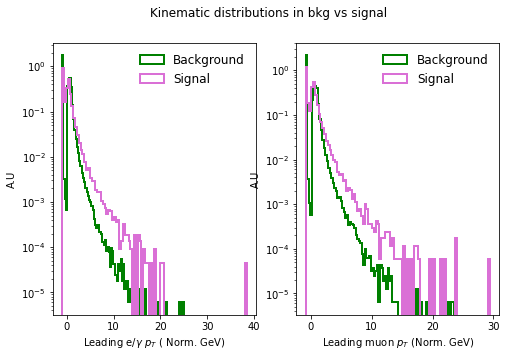

In [4]:
import matplotlib.pyplot as plt

print(" Training (#samples,#features):", X_train.shape)
print(" Testing  (#samples,#features):", signal_test_data.shape)

fig, axs = plt.subplots(1,2,figsize=(8,5))
fig.suptitle('Kinematic distributions in bkg vs signal')

axs[0].hist(X_train[:,3],bins=100,label=r'Background',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[0].hist(signal_test_data[:,3],bins=100,label=r'Signal',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[0].semilogy()
axs[0].set(xlabel=u'Leading e/$\gamma$ $p_{T}$ ( Norm. GeV)', ylabel='A.U')
axs[0].legend(loc='best',frameon=False, ncol=1,fontsize='large')

axs[1].hist(X_train[:,15],bins=100,label=r'Background',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[1].hist(signal_test_data[:,15],bins=100,label=r'Signal',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[1].set(xlabel=u'Leading muon $p_{T}$ (Norm. GeV)', ylabel='A.U')
axs[1].semilogy()
axs[1].legend(loc='best',frameon=False, ncol=1,fontsize='large')
print("Example data (1,57):",signal_test_data[3])

# Defining the autoencoder

Now, let's define an autoencoder to learn to reconstruct the training data after compressing it through a bottleneck, then decompressing it again.

<img src="images/ae.png" alt="The autoencoder" width="800" img align="center"/>

For that, we need a stack of dense layers:

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU

input_shape = 57
latent_dim = 3
#encoder
inputArray = Input(shape=(input_shape,))
#x = BatchNormalization()(inputArray) #Only use this if you're not standardizing the pT
x = Dense(32, kernel_initializer=tf.keras.initializers.HeUniform())(inputArray)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dense(16, kernel_initializer=tf.keras.initializers.HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)

#bottleneck
encoder = Dense(latent_dim, kernel_initializer=tf.keras.initializers.HeUniform())(x)

#decoder
x = Dense(16, kernel_initializer=tf.keras.initializers.HeUniform())(encoder)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dense(32, kernel_initializer=tf.keras.initializers.HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
decoder = Dense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform(), name='output')(x)

#create autoencoder
autoencoder = Model(inputs = inputArray, outputs=decoder)
autoencoder.summary()

# save the encoder-only model for easy access to latent space
encoder_model = Model(inputs=inputArray, outputs=encoder, name="encoder")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 57)]              0         
                                                                 
 dense (Dense)               (None, 32)                1856      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                             

2025-06-05 02:56:47.044109: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='mse')

# Let's train!

In [7]:
train = True #If you have a pre-trained model you can set this to false and load the other instead
EPOCHS = 50
BATCH_SIZE = 1024

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

callbacks=[]
callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
callbacks.append(TerminateOnNaN())

if train:
    history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val),
                  callbacks=callbacks)
    # Save the model
    autoencoder.save('baseline_ae.h5')
    autoencoder.save_weights('baseline_ae_weights_only.h5')
    
else:
    autoencoder = tf.keras.models.load_model('baseline_ae.h5')

Epoch 1/50
625/625 [==============================] - 3s 4ms/step - loss: 1.5312 - val_loss: 1.7474 - lr: 1.0000e-05
Epoch 2/50
625/625 [==============================] - 3s 4ms/step - loss: 1.3356 - val_loss: 1.4724 - lr: 1.0000e-05
Epoch 3/50
625/625 [==============================] - 3s 4ms/step - loss: 1.1759 - val_loss: 1.5466 - lr: 1.0000e-05
Epoch 4/50
625/625 [==============================] - 2s 4ms/step - loss: 1.0437 - val_loss: 1.2641 - lr: 1.0000e-05
Epoch 5/50
625/625 [==============================] - 2s 4ms/step - loss: 0.9335 - val_loss: 1.0530 - lr: 1.0000e-05
Epoch 6/50
625/625 [==============================] - 3s 4ms/step - loss: 0.8422 - val_loss: 0.9044 - lr: 1.0000e-05
Epoch 7/50
625/625 [==============================] - 3s 4ms/step - loss: 0.7674 - val_loss: 0.9343 - lr: 1.0000e-05
Epoch 8/50
625/625 [==============================] - 3s 5ms/step - loss: 0.7050 - val_loss: 0.7904 - lr: 1.0000e-05
Epoch 9/50
625/625 [==============================] - 2s 4ms/ste

# Evaluating the model performance

Remember that the key metric we use for anomaly detection is the mean-squared-error: If the error is high, the data is more likely to be anomalous, and if the error is low, the data is similar to the training data (which in our case is SM events). We therefore first need to run `model.predict()` in order to get the AE reconstructed output, both for our vanilla SM test data, and for our new leptoquark signal!

In [8]:
bkg_prediction = autoencoder.predict(X_test)
signal_prediction = autoencoder.predict(signal_test_data)

Let's see how well the network reconstructs the transverse momentum of the leptons!

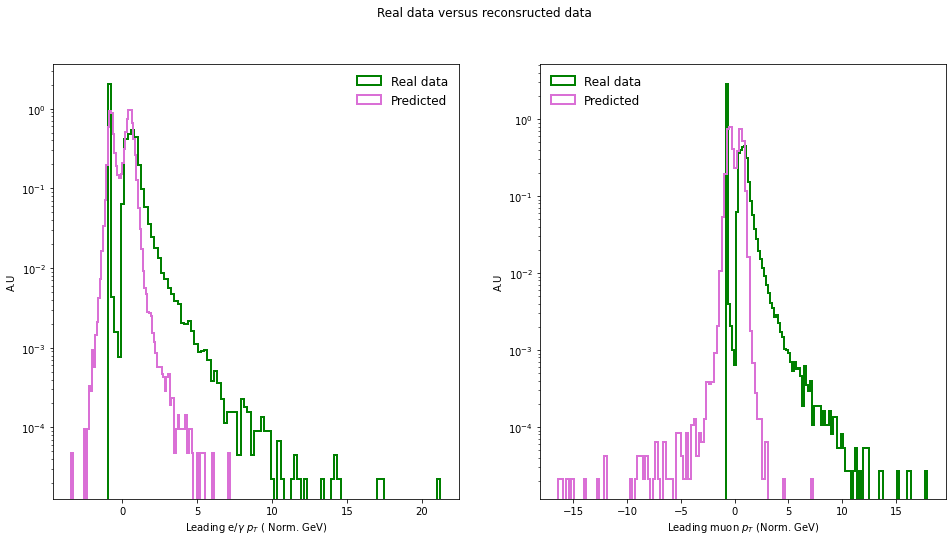

In [9]:
fig, axs = plt.subplots(1,2,figsize=(16,8))
fig.suptitle('Real data versus reconsructed data')
axs[0].hist(X_test[:,3],bins=100,label=r'Real data',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[0].hist(bkg_prediction[:,3],bins=100,label=r'Predicted',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[0].semilogy()
axs[0].set(xlabel=u'Leading e/$\gamma$ $p_{T}$ ( Norm. GeV)', ylabel='A.U')
axs[0].legend(loc='best',frameon=False, ncol=1,fontsize='large')

axs[1].hist(X_test[:,15],bins=100,label=r'Real data',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[1].hist(bkg_prediction[:,15],bins=100,label=r'Predicted',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[1].set(xlabel=u'Leading muon $p_{T}$ (Norm. GeV)', ylabel='A.U')
axs[1].semilogy()
axs[1].legend(loc='best',frameon=False, ncol=1,fontsize='large')

The reconstructed $p_T$ has an unphysical tail below zero. For a real usecase, we would force the output to be positive for that column, as well as treat the zero-padded cases differently in the loss.
To keep it short, we won't do that now, but you can read more about it [here](https://arxiv.org/abs/2108.03986)

We then need to compute the mean-square-error, which will be our final discriminating variable. This you would need to write custom if applying the changes we mention above:

In [10]:
def mse_loss(true, prediction):
    loss = tf.reduce_mean(tf.math.square(true - prediction),axis=-1)
    return loss

# compute loss value of input data versus AE reconstructed data
mse_sm = mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy()
mse_bsm = mse_loss(signal_test_data,signal_prediction.astype(np.float32)).numpy()

Now, let's look at our discriminant!

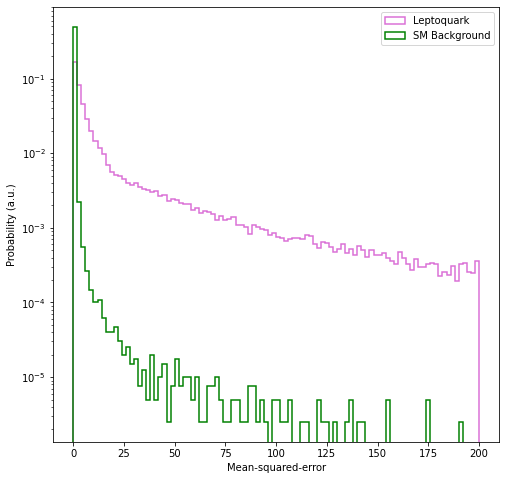

In [11]:
bin_size=100

plt.figure(figsize=(8,8))
n, bins, patches =plt.hist(mse_bsm, bins=bin_size, label="Leptoquark", density = True, histtype='step', fill=False, edgecolor='orchid', linewidth=1.5,range=[0,200])
n_, bins_, patches_ =plt.hist(mse_sm, bins=bin_size, label="SM Background", density = True, histtype='step', fill=False, edgecolor='green', linewidth=1.5,range=[0,200])
plt.yscale('log')
plt.xlabel("Mean-squared-error")
plt.ylabel("Probability (a.u.)")
plt.legend(loc='best')
plt.show()

There seems to be some discrimination power if we cut at very high values of the MSE! Let's look at a ROC curve to make it easier to vizualize

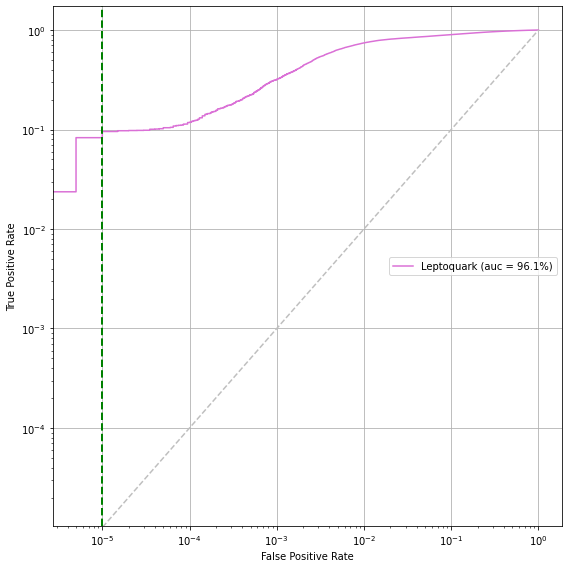

In [12]:
from sklearn.metrics import roc_curve, auc

target_background = np.zeros(mse_sm.shape[0])

plt.figure(figsize=(8,8))
trueVal = np.concatenate((np.ones(mse_bsm.shape[0]), target_background)) # anomaly=1, bkg=0
predVal_loss = np.concatenate((mse_bsm, mse_sm))

fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

auc_loss = auc(fpr_loss, tpr_loss)
    
plt.plot(fpr_loss, tpr_loss, "-", label='Leptoquark (auc = %.1f%%)'%(auc_loss*100.), linewidth=1.5, color = "orchid")
    
plt.semilogx()
plt.semilogy()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='green', linestyle='dashed', linewidth=2) # threshold value for measuring anomaly detection efficiency
plt.show()

Pretty good! So at a false positive rate of 10E-5, the signal efficiency is almost three orders of magnitude higher! This can obviously be further improved, but I leave that up to you :)

# Model compression
<img src="images/nmi_qkeras_hls4ml.jpeg" alt="hls4ml and qkeras" width="200" img align="left"/>

Now, there is absolutely no way anyone would let you deploy this model on an FPGA in the trigger. It will use far too many resources! Luckily, as we discussed in the lecture, there are some cheap tricks you can perform to compress the model. These are pruning and quantization-aware-training and both are very easily implemented. Let's have a look.

To quantize the model during training, such that the network will get the opportunity to adapt to the narrower bitwidth we use the library [QKeras](https://www.nature.com/articles/s42256-021-00356-5.epdf?sharing_token=A6MQVmmncHNyCtDUXzrqtNRgN0jAjWel9jnR3ZoTv0N3uekY-CrHD1aJ9BTeJNRfQ1EhZ9jJIhgZjfrQxrmxMLMZ4eGzSeru7-ASFE-Xt3NVE6yorlffwUN0muAm1auU2I6-5ug4bOLCRYvA0mp-iT-OdPsrBYeH0IHRYx0t3wc%3D), developed in a joint effort between CERN and Google.

## Quantization aware training with QKeras

# Quantization aware training with QKeras

Quantization is a powerful way to reduce model memory and resource consumption. In this tutorial, we will use the libary QKeras to perform quantization aware training (QAT).

In contrast to in Keras, where models are trained using floating point precision, QKeras quantizes each of the model weights and activation functions during training, allowing the network to adapt to the numerical precision that will eventually be used on hardware.

During the forward pass of the network, each floating point weight is put into one of $2^{bitwidth}$ buckets. Which one it goes into is defined through rounding and clipping schemes.

Below you can see an example of a tensor with a (symmetric) dynamic range of $x_{f}$ $[-amax, amax]$ mapped through quantization to a an 8 bit integer, $2^8=256$ discrete values in the interval $[-128, 127]$ (32-bit floating-point can represent ~4B numbers in the interval $[-3.4e38, 3.40e38]$).

<img src="https://gitlab.cern.ch/fastmachinelearning/cms_mlatl1t_tutorial/-/raw/master/part2/images/8-bit-signed-integer-quantization.png?ref_type=heads" width="800"/>

Quantization of floating point numbers can be achieved using the quantization operation

$$x_{q} = Clip(Round(x_{f}/scale))$$

where $x_{q}$ is the quantized digit and $x_{f}$ is the floating point digit. $Round$ is a function that applies some rounding scheme to each number and $Clip$ is a function that clips outliers that fall outside the $[-128, 127]$ interval. The $scale$ parameter is obtained by dividing the float-point dynamic-range into 256 equal parts.

On FPGA, we do not use int8 quantization, but fixed-point quantization, bu the idea is similar. Fixed-point representation is a way to express fractions with integers and offers more control over precision and range. We can split the $W$-bits making up an integer (in our case $W=8$) to represent the integer part of a number and the fractional part of the number. We usually reserve 1-bit representing the sign of the digit. The radix splits the remaining $W-1$ bits to $I$ most significant bits representing the integer value and $F$ least significant bits representing the fraction. We write this as $<W,I>$, where $F=W-1-I$.  Here is an example for an unsigned $<8,3>$:

<img src="https://gitlab.cern.ch/fastmachinelearning/cms_mlatl1t_tutorial/-/raw/master/part2/images/fixedpoint.png?ref_type=heads" width="400"/>


This fixed point number corresponds to $2^4\cdot0+2^3\cdot0+2^2\cdot0+2^1\cdot1+2^0\cdot0+2^{-1}\cdot1+2^{-2}\cdot1+2^{-3}\cdot0=2.75$.

The choice of $I$ and $F$ has to be derived as a trade-off between representation range and precision, where $I$ controls the range and $F$ the precision.

In the following we will use a bitwidth of 8 and 0 integer bits. Not considering the sign bit, this means that the smallest number you can represent (the precision) and the largest number (the range) is:

$$ \rm{Precision}= \frac{1}{2^{F}}= \frac{1}{2^8} = 0.00390625$$
$$\rm{Range}= [-2^0,-2^0-1]=[-1,0] $$
With zero integer bits the largest number you can represent is just below (but not including) 1. For weights in deep neural networks, being constrained to be less than 1 is often a reasonable assumtion.



What QKeras (and other QAT libraries) do, is to include the quantization error during the training, in the following way:
- "Fake quantize" the floating-point weights and activations during the forward pass: quantize the weights and use them for the layer operations
- Immediately un-quantize the parameters so the rest of the computations take place in floating-point
- During the backward pass, the gradient of the weights is used to update the floating point weight
- The quantization operation gradient (zero or undefined) is handled by passing the gradient through as is ("straight through estimator")



In [13]:
from qkeras import QDense, QActivation

#encoder
inputArray = Input(shape=(input_shape,))
# x = BatchNormalization()(inputArray)
x = QDense(32, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(8,3,1, alpha=1.0)',
               bias_quantizer='quantized_bits(8,3,1, alpha=1.0)')(inputArray)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=8)')(x)
x = QDense(16, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(8,3,1, alpha=1.0)',
               bias_quantizer='quantized_bits(8,3,1, alpha=1.0)')(x)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=8)')(x)
encoder = QDense(latent_dim, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(16,6,1, alpha=1.0)',
               bias_quantizer='quantized_bits(16,6,1, alpha=1.0)', name='bottleneck')(x)

#decoder
x = QDense(16, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(8,3,1, alpha=1.0)',
               bias_quantizer='quantized_bits(8,3,1, alpha=1.0)')(encoder)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=8)')(x)
x = QDense(32, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(8,3,1, alpha=1.0)',
               bias_quantizer='quantized_bits(8,3,1, alpha=1.0)')(x)
x = BatchNormalization()(x)
x = QActivation('quantized_relu(bits=8)')(x)
decoder = QDense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform(),
               kernel_quantizer='quantized_bits(16,6,1, alpha=1.0)',
               bias_quantizer='quantized_bits(16,6,1, alpha=1.0)', name='output')(x)

#create autoencoder
q_autoencoder = Model(inputs = inputArray, outputs=decoder)
q_autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 57)]              0         
                                                                 
 q_dense (QDense)            (None, 32)                1856      
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 q_activation (QActivation)  (None, 32)                0         
                                                                 
 q_dense_1 (QDense)          (None, 16)                528       
                                                                 
 batch_normalization_5 (Batc  (None, 16)               64        
 hNormalization)                                           

Wait! What is going on here?
The magic happens in ```quantized_bits``` (see implementation [here](https://github.com/google/qkeras/blob/master/qkeras/quantizers.py#L1245)), where the parameters are the following:
- ```bits```: The bitwidth, allowing you to have $2^{bits}$ unique values of each weight parameter
- ```integers```: How many are integer bits, in this case zero. All 8 bits are used to represent the fractional part of the weight parameter, with no bits dedicated to representing whole numbers. This forces the value to be between -1 and 1. For DNNs this can be useful because the focus is entirely on the precision of the fraction rather than the magnitude of the number. Question: Would this also work on the output node if your algorithm is a regression of the jet mass?
- ```symmetric```: should the values be symmetric around 0? In this case it doesnt have to be.
- ```alpha```: with $2^W$ unique values available, we could let them go from $[-2^W, 2^W-1]$ like above, but we can also let them go from $[-2^W*\alpha, (2^W-1)*\alpha]$. ```alpha``` is a scaling of the weights. Enabling this often leads to improved performance, but it doesnt talk so nicely to hls4ml, so we recommend leaving it at 1 (or get ready for having to debug)

Having added this, QKeras will automatically apply fake quantization for us during the forward pass, accounting for the quantization error and returning a network that is optimized for the precision you plan on using in hardware.

Another thing to notice is that we leave the sigmoid and the final output logit unquantized. This is because this is were we want the values to be very accurate, and it is not going to save us a lot of resources quantizing it.


### Automatic model quantization through config
 You can also set the quantization for the full model using a model configuration. Sometimes this can be sater if you're using the same quantizer for all layers of the same type. You don't have to use this for this tutorial, we already have a model, but we will leave it here as an example:

In [14]:
autoQuant = False

if autoQuant:
    config = {
      "QDense": {
          "kernel_quantizer": "quantized_bits(bits=8, integer=0, symmetric=0, alpha=1)",
          "bias_quantizer": "quantized_bits(bits=8, integer=0, symmetric=0, alpha=1)",
      },
      "QActivation": { "relu": "quantized_relu(8)" }
    }
    from qkeras.utils import model_quantize

    qmodel = model_quantize(model, config, 4, transfer_weights=True)

    for layer in qmodel.layers:
        if hasattr(layer, "kernel_quantizer"):
            print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
        elif hasattr(layer, "quantizer"):
            print(layer.name, "quantizer:", str(layer.quantizer))

    print()
    qmodel.summary()


## But how many bits?

So now we know how to quantize our models, but how do we know wich precision to choose?
Finding the best number of bits and integer bits to use is non-trivial, and there are two ways we recommend:
- The easiest strategy is to scan over the possible bit widths from binary up to some maximum value and choose the smallest one that still has acceptable accuracy, and this is what we often do. 
Code for how to do this can be found [here](https://github.com/thesps/keras-training/blob/qkeras/train/train_scan_models.py#L16), and is illustrated below.
For binary and ternary quantization, we use the special ```binary(alpha=1.0)(x)``` and ```ternary(alpha=1.0)(x)``` quantizers. 

<img src="https://gitlab.cern.ch/fastmachinelearning/cms_mlatl1t_tutorial/-/raw/master/part2/images/quant_scan.png?ref_type=heads" width="400"/>

- Another thing you can do is to use our library for automatic quantization, [AutoQKeras](https://github.com/google/qkeras/blob/master/notebook/AutoQKeras.ipynb), to find the optimal quantization for each layer. This runs hyperparameter optimisation over quantizers/nodes/filters simultenously. An example can be found at the end of [this notebook](https://github.com/fastmachinelearning/hls4ml-tutorial/blob/main/part6_cnns.ipynb) "Bonus exercise: Automatic quantization with AutoQKeras".

## Pruning

Besides reducing the numerical precision of all the weights, biases and activations, I also want to remove neurons and synapses that do not contribute much to the network overall decision. We do that by pruning, let's remove 50\% of the weights (spasity=0.5):

Easy as that! Let's add some pruning on top, 50% sparsity (removing 50% of the weights). Let's make sure to skip our latent dimension!

In [15]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

def pruneFunction(layer):
    pruning_params = {'pruning_schedule': pruning_schedule.PolynomialDecay(initial_sparsity=0.05,final_sparsity=0.50, begin_step=0, end_step=100, frequency=100)}
    if isinstance(layer, tf.keras.layers.Dense) and layer.name!='bottleneck':
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)  
    return layer

q_autoencoder.load_weights('baseline_ae_weights_only.h5')
qp_autoencoder = tf.keras.models.clone_model( q_autoencoder, clone_function=pruneFunction)
qp_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='mse')

/Users/thea/miniconda3/envs/ad_pynq/lib/python3.9/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:212: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  mask = self.add_variable(
/Users/thea/miniconda3/envs/ad_pynq/lib/python3.9/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:219: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  threshold = self.add_variable(
/Users/thea/miniconda3/envs/ad_pynq/lib/python3.9/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:233: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.pruning_step = self.add_variable(


## Defining the data input type
Great, we now have our model ready to be trained! There is one last important thing we have to think about and that is the *precision of the input*.  In hardware, all of the inputs are quantized.

Ideally, when you train your network, you use the hardware values that the algorithm will actually receive when running inference in the trigger.

If the inputs were all scaled to have a mean of zero and variance of one, rhat means that the new optimal precision for the inputs have changed and you need to define what the precision will be. Here we will do it by inspection and intuition, and use the same precision for all of the input features. Let's look at the full input value distribution:

<module 'matplotlib.pyplot' from '/Users/thea/miniconda3/envs/ad_pynq/lib/python3.9/site-packages/matplotlib/pyplot.py'>

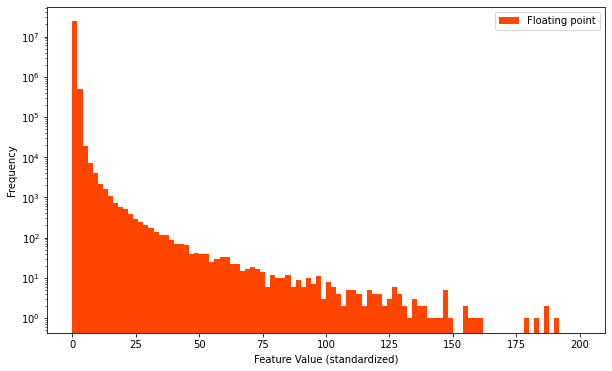

In [ ]:

# import matplotlib.pyplot as plt



# plt.figure(figsize=(10, 6))
# #Input distribution, stacked per feature. This is very slow to plot, so lets look at all the features flattened later on
# plt.hist(X_train, bins=bins, stacked=True, label=[f'Input {i+1}' for i in range(X_train.shape[1])]) 
# # plt.hist(X_train.flatten(), bins=bins, color='orangered', label='Floating point')
# plt.xlabel('Feature Value (standardized)')
# plt.ylabel('Frequency')
# plt.legend(loc='upper right', ncol=2)
# plt.semilogy()
# plt

bins = 4096
plt.figure(figsize=(10, 6))

# plt.hist(qX_train, bins=bins, stacked=True, label=[f'Input {i+1}' for i in range(X_train.shape[1])])
plt.hist(X_train.flatten(), bins=bins, color='orangered', label='Floating point')
plt.xlabel('Feature Value (standardized)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', ncol=2)
plt.semilogy()
plt


### <span style="color:green">This takes a minute to plot, read on while you wait (2 minutes)</span>

In this case, the values seem to be mostly <100, with a few outliers so lets assume 8 integer bits ($2^8=256$) is sufficient (the rest will get clipped). The number of fractional bits will define our precision, and will affect the network performance. Let's assume 10 is sufficient (the smallest increment we can represent is $2^{-10}=0.0009765625$).

We can evaluate these choices by comparing the accuracy of the network to that in the previous part. 

To make our network adapt to this input precision, we need to "treat" our training and testing set with a quantizer to go from FP32 $\rightarrow <18,8>$:

In [17]:
import numpy as np
from qkeras.quantizers import quantized_bits, quantized_relu
input_quantizer = quantized_bits(bits=18, integer=8, symmetric=0, alpha=1)
qX_train = input_quantizer(X_train.astype(np.float32)).numpy()
qX_test = input_quantizer(X_test.astype(np.float32)).numpy()

# Save the quantized test data and labels to a numpy file, such that it can be used to test the firmware
np.save('qX_test.npy', qX_test)


<module 'matplotlib.pyplot' from '/Users/thea/miniconda3/envs/ad_pynq/lib/python3.9/site-packages/matplotlib/pyplot.py'>

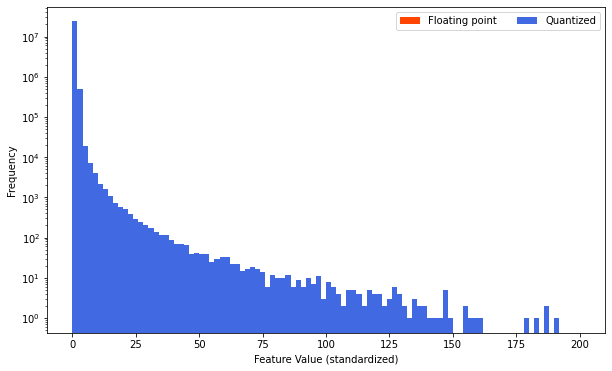

In [18]:
plt.figure(figsize=(10, 6))

# plt.hist(qX_train, bins=bins, stacked=True, label=[f'Input {i+1}' for i in range(X_train.shape[1])])
plt.hist(X_train.flatten(), bins=bins, color='orangered', label='Floating point')
plt.hist(qX_train.flatten(), bins=bins, color='royalblue', label='Quantized')
plt.xlabel('Feature Value (standardized)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', ncol=2)
plt.semilogy()
plt

The value distribution looks similar, but we can not really say how much we lose in performance before training with different input precisions.

## Train the network quantization aware
Phew, okay, finally time to train. For this part there are 2 things to note: you need to add a pruning callback and also you might need to adjust the learning rate (like add a learning rate decay). Also, most likely you need to increase the number of epochs.

Let's train!

In [19]:
train = True
EPOCHS = 50
BATCH_SIZE = 1024

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

callbacks=[]
callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
callbacks.append(TerminateOnNaN())
callbacks.append(pruning_callbacks.UpdatePruningStep())
if train:
        
    history = qp_autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val),
                  callbacks=callbacks)
    # Save the model
    qp_autoencoder = strip_pruning(qp_autoencoder)
    qp_autoencoder.save('qkeras_ae.h5')
    
else:
    from qkeras.utils import _add_supported_quantized_objects
    co = {}; _add_supported_quantized_objects(co)

    qp_autoencoder = tf.keras.models.load_model('qkeras_ae.h5',custom_objects=co)
    

Epoch 1/50
625/625 [==============================] - 13s 11ms/step - loss: 0.6206 - val_loss: 0.5886 - lr: 1.0000e-05
Epoch 2/50
625/625 [==============================] - 5s 7ms/step - loss: 0.6126 - val_loss: 0.5643 - lr: 1.0000e-05
Epoch 3/50
625/625 [==============================] - 4s 7ms/step - loss: 0.5900 - val_loss: 0.5437 - lr: 1.0000e-05
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 0.5723 - val_loss: 0.5293 - lr: 1.0000e-05
Epoch 5/50
625/625 [==============================] - 4s 7ms/step - loss: 0.5568 - val_loss: 0.5145 - lr: 1.0000e-05
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.5435 - val_loss: 0.5023 - lr: 1.0000e-05
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 0.5313 - val_loss: 0.4914 - lr: 1.0000e-05
Epoch 8/50
625/625 [==============================] - 4s 6ms/step - loss: 0.5206 - val_loss: 0.4808 - lr: 1.0000e-05
Epoch 9/50
625/625 [==============================] - 4s 6ms/s

Let's quickly check that the pruning worked and 30% of the weights are indeed 0!

Layer dense: % of zeros = 0.0
Layer dense_1: % of zeros = 0.0
Layer dense_2: % of zeros = 0.0
Layer dense_3: % of zeros = 0.0
Layer dense_4: % of zeros = 0.0
Layer output: % of zeros = 0.0
Layer q_dense: % of zeros = 0.5
Layer q_dense_1: % of zeros = 0.5
Layer bottleneck: % of zeros = 0.0
Layer q_dense_2: % of zeros = 0.5
Layer q_dense_3: % of zeros = 0.5
Layer output: % of zeros = 0.5


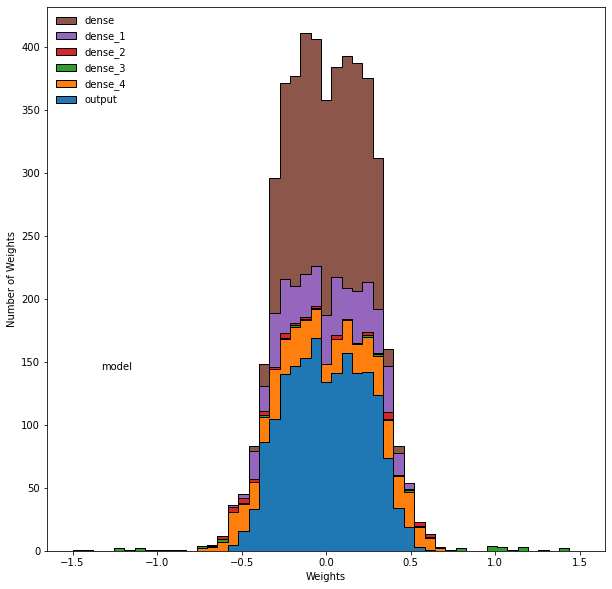

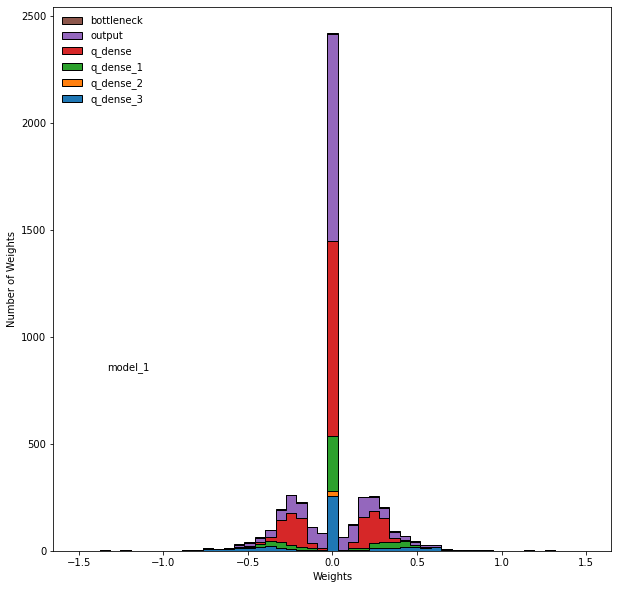

In [20]:
def doWeights(model):

    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch")!=-1 or len(layer.get_weights())<1:
            continue 
        weights=layer.weights[0].numpy().flatten()  
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name,np.sum(weights==0)/np.size(weights)))

    labelsW = []
    histosW = []

    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    fig = plt.figure(figsize=(10,10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW,bins,histtype='stepfilled',stacked=True,label=labelsW, edgecolor='black')
    plt.legend(frameon=False,loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    plt.figtext(0.2, 0.38,model._name, wrap=True, horizontalalignment='left',verticalalignment='center')
    
doWeights(autoencoder) 
doWeights(qp_autoencoder) 

Indeed, a huge spike at zero for the pruned model! Let's compare the performance to the floating point precision, unpruned model:

In [21]:
bkg_prediction = qp_autoencoder.predict(X_test)
signal_prediction = qp_autoencoder.predict(signal_test_data)

# compute loss value of input data versus AE reconstructed data
q_mse_sm = mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy()
q_mse_bsm = mse_loss(signal_test_data,signal_prediction.astype(np.float32)).numpy()

target_background = np.zeros(q_mse_sm.shape[0])

plt.figure(figsize=(8,8))
trueVal = np.concatenate((np.ones(q_mse_bsm.shape[0]), target_background)) # anomaly=1, bkg=0
predVal_loss = np.concatenate((q_mse_bsm, q_mse_sm))

q_fpr_loss, q_tpr_loss, q_threshold_loss = roc_curve(trueVal, predVal_loss)

q_auc_loss = auc(q_fpr_loss, q_tpr_loss)

<Figure size 576x576 with 0 Axes>

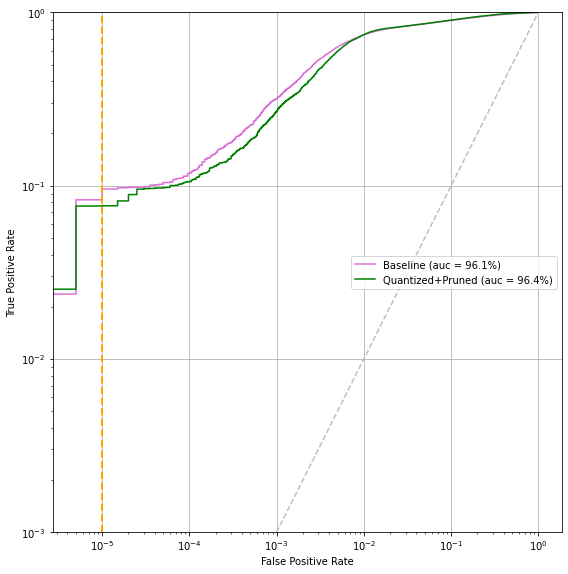

In [22]:
plt.figure(figsize=(8,8))
    
plt.plot(fpr_loss, tpr_loss, "-", label='Baseline (auc = %.1f%%)'%(auc_loss*100.), linewidth=1.5, color = "orchid")
plt.plot(q_fpr_loss, q_tpr_loss, "-", label='Quantized+Pruned (auc = %.1f%%)'%(q_auc_loss*100.), linewidth=1.5, color = "green")

plt.semilogx()
plt.semilogy()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.ylim(0.001,1)
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='orange', linestyle='dashed', linewidth=2) # threshold value for measuring anomaly detection efficiency
plt.show()

Take a moment to appreciate what an absolutely fantastic result this is! 

We can reduce the numerical precision of the model from floating point 32 representation to 8-bit fixed point precision, remove 50% of the weights *and still get the same performance*!! This is a crucial, and absolutely neccessary, part of making deep neural networks in particle detector data aquisition systems a reality (also, note that AUC is not a good metric for trigger applications, where you typically operate at very low false positive rates of 10E-5).



So it seems despite having reduced the numerical precision of the model and the input, as well as removing 50% of the model weights, we're doing pretty good! This can be tuned to get even better, by carefully adjusting the input precision and the model precision, especially increaseing the precision of the logit layer.


Now some exersices on AD before we move to firmware!


# Exercises

- Perform a PCA on the training images using sklearn.decomposition.PCA with 2 components.

- Plot the PCA ROC curve. Report the AUC.

- Plot the 2D latent space for signal and background

- Turn the AE into a VAE:

- Which is the better anomaly detection algorithm? 
- How can you improve the performance?




........








.......






Some hints:

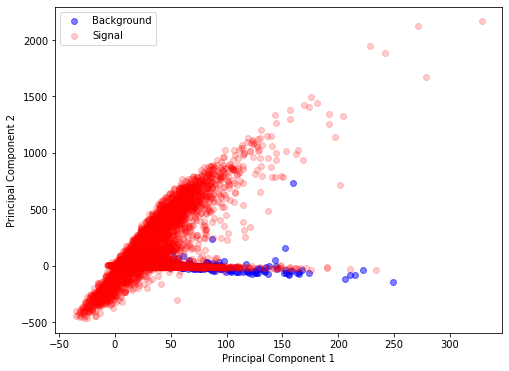

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Transform signal using  same scaler and PCA
signal_test_scaled = scaler.transform(signal_test_data)
signal_test_pca = pca.transform(signal_test_scaled)

# Step 3: Plot both
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c='blue', label='Background')
plt.scatter(signal_test_pca[:, 0], signal_test_pca[:, 1], alpha=0.2, c='red', label='Signal')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

plt.show()




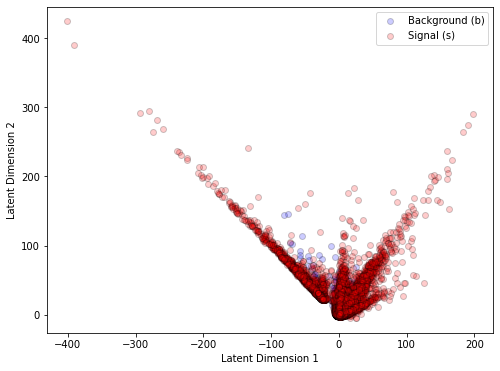

In [24]:
# Encode the test data to latent space
latent_representations_b = encoder_model.predict(X_test)
latent_representations_s = encoder_model.predict(signal_test_data)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(latent_representations_b[:, 0], latent_representations_b[:, 1], 
            alpha=0.2, c='blue', edgecolor='k', label='Background (b)')
plt.scatter(latent_representations_s[:, 0], latent_representations_s[:, 1], 
            alpha=0.2, c='red', edgecolor='k', label='Signal (s)')
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()


# Let's go variational!


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, LeakyReLU
from tensorflow.keras import backend as K

# Dimensions
input_shape = 57
latent_dim = 2

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Input
inputArray = Input(shape=(input_shape,))

# Encoder
x = Dense(32, kernel_initializer=tf.keras.initializers.HeUniform())(inputArray)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = Dense(16, kernel_initializer=tf.keras.initializers.HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)

# Bottleneck
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder
decoder_input = Dense(16, kernel_initializer=tf.keras.initializers.HeUniform())(z)
decoder_input = BatchNormalization()(decoder_input)
decoder_input = LeakyReLU(alpha=0.3)(decoder_input)
decoder_input = Dense(32, kernel_initializer=tf.keras.initializers.HeUniform())(decoder_input)
decoder_input = BatchNormalization()(decoder_input)
decoder_input = LeakyReLU(alpha=0.3)(decoder_input)
output = Dense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform())(decoder_input)

# VAE model
vae = Model(inputArray, output, name="vae")

# Custom loss
reconstruction_loss = tf.keras.losses.mse(inputArray, output)
reconstruction_loss = tf.reduce_mean(reconstruction_loss) * input_shape

kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
kl_loss = tf.reduce_mean(kl_loss)

vae_loss = reconstruction_loss + 0.02*kl_loss
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.summary()

# Save encoder
vae_encoder = Model(inputs=inputArray, outputs=z_mean, name="encoder")  # use z if you want noisy samples


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 32)           1856        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 32)          128         ['dense_5[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 32)           0           ['batch_normalization_8[0][0]']

In [26]:
history = vae.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val),
                  callbacks=callbacks)

Epoch 1/50
625/625 [==============================] - 6s 8ms/step - loss: 29.4568 - val_loss: 20.8461 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 22.1920 - val_loss: 18.6125 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 4s 7ms/step - loss: 20.3721 - val_loss: 17.6288 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 4s 7ms/step - loss: 19.0920 - val_loss: 16.9499 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 18.1820 - val_loss: 16.4439 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 17.5643 - val_loss: 19.9922 - lr: 0.0010
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 16.8865 - val_loss: 15.2796 - lr: 0.0010
Epoch 8/50
625/625 [==============================] - 3s 5ms/step - loss: 16.4531 - val_loss: 14.3314 - lr: 0.0010
Epoch 9/50
625/625 [==============================] - 4s 6ms/step - loss: 15.892

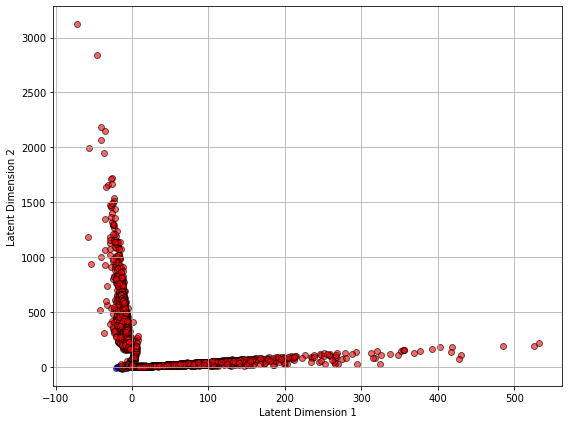

In [27]:
# Encode the test data to latent space
latent_representations_vae_b = vae_encoder.predict(X_test)
latent_representations_vae_s = vae_encoder.predict(signal_test_data)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(latent_representations_vae_b[:, 0], latent_representations_vae_b[:, 1], alpha=0.6, c='blue', edgecolor='k')
plt.scatter(latent_representations_vae_s[:, 0], latent_representations_vae_s[:, 1], alpha=0.6, c='red', edgecolor='k')
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()